# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

%matplotlib inline

# Prepare Dataset

In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.MNIST(root='Data/', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='Data/', train=False, download=True, transform=transform)

In [4]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: Data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: Data/
    Split: Test
    StandardTransform
Transform: ToTensor()

In [6]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [7]:
# in_channels = 1 because of gray scale image
# out_channels = 6, feature extractions, 6 Filters
# kernel_size = 3, means 3X3 size karnel
# stride = 1 num of steps to move each time

conv1 = nn.Conv2d(
            in_channels=1, 
            out_channels=6, 
            kernel_size=3, 
            stride=1, 
        )

In [8]:
# in_channels = out_channels of previous conv layer
conv2 = nn.Conv2d(
            in_channels=6, 
            out_channels=16, 
            kernel_size=3, 
            stride=1, 
        )

In [19]:
for i, (image, label) in enumerate(train_data, 1):
    break

In [20]:
image.shape

torch.Size([1, 28, 28])

In [21]:
label

5

In [22]:
x = image.view(1,1,28,28) #--> 4D (b,c,w,h)

In [23]:
x.shape

torch.Size([1, 1, 28, 28])

In [24]:
x = F.relu(conv1(x))

In [25]:
x.shape

torch.Size([1, 6, 26, 26])

In [26]:
x = F.max_pool2d(x,2,2) #--> image, kernel size = 2x2, stride=2

In [27]:
x.shape

torch.Size([1, 6, 13, 13])

In [28]:
 x = F.relu(conv2(x))

In [29]:
x.shape

torch.Size([1, 16, 11, 11])

In [30]:
x = F.max_pool2d(x, 2, 2)

In [31]:
x.shape

torch.Size([1, 16, 5, 5])

In [32]:
(((28-2)//2)-2)//2

5

In [34]:
x.view(-1, 16*5*5).shape

torch.Size([1, 400])

# Using Conv Class

In [48]:
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1,16*5*5)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        pred = F.log_softmax(X, dim=1)
        return pred

In [49]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [50]:
for param in model.parameters():
    print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


In [51]:
# Hyper Parameters
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [52]:
from time import time
start_time = time()

EPOCHS = 5

train_losses = []
test_losses = []

train_correct = []
test_correct = []


for epoch in range(1, EPOCHS+1):
    trn_corr = 0 
    tst_corr = 0 
    
    # Train 
    for b, (X_train, y_train) in enumerate(train_loader, 1):
        y_pred = model(X_train) # Not Flatten!
        loss = criterion(y_pred, y_train)
        
        pred = torch.max(y_pred.data, 1)[1]
        batch_corr = (pred == y_train).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%600==0:
            print(f"EPOCH: {epoch} BATCH: {b} LOSS: {loss.item()}")
        
    train_losses.append(loss.item())
    train_correct.append(trn_corr)
    
    # TEST
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader, 1):
            y_pred = model(X_test) # Not Flatten!
            loss = criterion(y_pred, y_test)

            pred = torch.max(y_pred.data, 1)[1]
            batch_corr = (pred == y_test).sum()
            tst_corr += batch_corr

    test_losses.append(loss.item())
    test_correct.append(tst_corr)

current_time = time()
print(f"Execution Time: {(current_time-start_time)/60:.2f} minutes")

EPOCH: 1 BATCH: 600 LOSS: 0.04255058243870735
EPOCH: 1 BATCH: 1200 LOSS: 0.07605954259634018
EPOCH: 1 BATCH: 1800 LOSS: 0.30995792150497437
EPOCH: 1 BATCH: 2400 LOSS: 0.020551541820168495
EPOCH: 1 BATCH: 3000 LOSS: 0.007200110703706741
EPOCH: 1 BATCH: 3600 LOSS: 0.0014925708528608084
EPOCH: 1 BATCH: 4200 LOSS: 0.5335163474082947
EPOCH: 1 BATCH: 4800 LOSS: 0.06265663355588913
EPOCH: 1 BATCH: 5400 LOSS: 0.01638302020728588
EPOCH: 1 BATCH: 6000 LOSS: 0.048138946294784546
EPOCH: 2 BATCH: 600 LOSS: 0.01610490307211876
EPOCH: 2 BATCH: 1200 LOSS: 0.03600595146417618
EPOCH: 2 BATCH: 1800 LOSS: 0.005278380122035742
EPOCH: 2 BATCH: 2400 LOSS: 0.03168891370296478
EPOCH: 2 BATCH: 3000 LOSS: 0.39624544978141785
EPOCH: 2 BATCH: 3600 LOSS: 0.004537445493042469
EPOCH: 2 BATCH: 4200 LOSS: 0.0004565873241517693
EPOCH: 2 BATCH: 4800 LOSS: 0.00044634751975536346
EPOCH: 2 BATCH: 5400 LOSS: 0.0018241051584482193
EPOCH: 2 BATCH: 6000 LOSS: 0.030887553468346596
EPOCH: 3 BATCH: 600 LOSS: 0.0009548375383019447


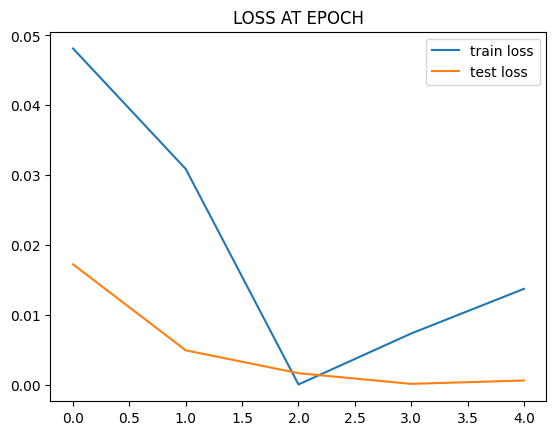

In [53]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.title("LOSS AT EPOCH")
plt.legend();

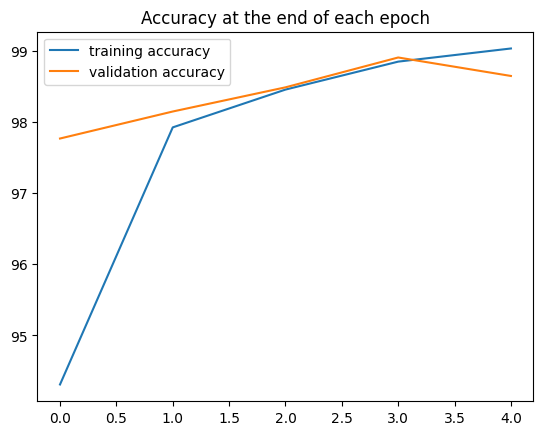

In [54]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title("Accuracy at the end of each epoch")
plt.legend();

In [56]:
test_loader_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [57]:
# TEST
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_loader_all:
        y_pred = model(X_test) # Not Flatten!

        pred = torch.max(y_pred.data, 1)[1]
        correct += (pred==y_test).sum()

In [63]:
correct.item()/len(test_data)

0.9865

In [72]:
# print a row of values for reference 
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print confusion matrix
print(confusion_matrix(y_test.view(-1), pred.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 974    0    1    0    0    0    3    1    1    0]
 [   5 1124    1    3    0    0    2    0    0    0]
 [   0    1 1018    5    1    0    0    5    2    0]
 [   0    0    0 1007    0    2    0    0    1    0]
 [   0    0    0    0  970    0    4    0    1    7]
 [   1    0    0   22    0  864    4    0    0    1]
 [   4    2    1    0    1    3  945    0    2    0]
 [   0    5    5    1    1    0    0 1011    2    3]
 [   2    0    1    2    0    1    0    1  965    2]
 [   0    0    0    5    6    4    0    1    6  987]]


# Inferance

In [88]:
img = test_data[2005][0].reshape(28,28)

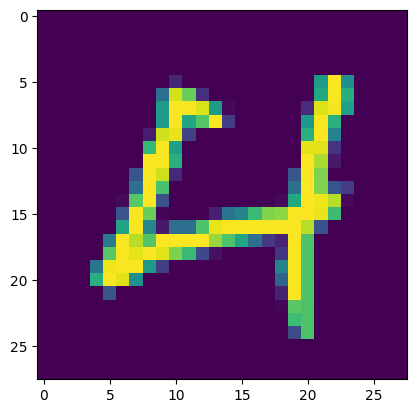

In [89]:
plt.imshow(img)
pass

In [90]:
model.eval()
with torch.no_grad():
    prediction = model(img.view(1,1,28,28))
    result = prediction.argmax()
result

tensor(4)